# Ramp rates near startup/shutdown
In the previous notebook I made a method to pick out downtime events. The next step is to calculate a distance, in hours, from each generation value to the previous startup and next shutdown. Then I can characterize startup/shutdown ramps vs 'normal' ramps

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ramprate.load_dataset import load_epacems
from ramprate.build_features import _find_uptime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
idx = pd.IndexSlice

In [4]:
# all states, 1 year
cols = ['operating_datetime_utc', 'operating_time_hours', 'gross_load_mw', 'unit_id_epa']
cems = load_epacems(states=None, years=[2019], columns=cols, engine='pandas')

In [5]:
%%time
cems.sort_values(by=['unit_id_epa', 'operating_datetime_utc'], inplace=True)
cems.set_index(['unit_id_epa', 'operating_datetime_utc'], drop=False, inplace=True)#, verify_integrity=True)

CPU times: user 12.5 s, sys: 3.14 s, total: 15.6 s
Wall time: 15.8 s


In [6]:
cems.sample(3)

,,operating_datetime_utc,operating_time_hours,gross_load_mw,unit_id_epa
unit_id_epa,operating_datetime_utc,,,,
2466,2019-02-26 05:00:00+00:00,2019-02-26 05:00:00+00:00,0.0,0.0,2466
4780,2019-02-09 13:00:00+00:00,2019-02-09 13:00:00+00:00,0.0,0.0,4780
4004,2019-06-20 17:00:00+00:00,2019-06-20 17:00:00+00:00,1.0,211.0,4004


In [7]:
units = cems.groupby(level=['unit_id_epa'])

In [8]:
cems['load_factor'] = units['gross_load_mw'].transform(lambda x: x.div(x.max()))
#cems['load_factor'] = units['gross_load_mw'].transform(lambda x: x.div(x[x>0].quantile(0.99)))

## Distance to startup/shutdown
For all non-zero generation, I want to calculate the hours since last startup and hours to next shutdown. Strategy is to make new columns with the nearest startup/shutdown timestamps and then subtract the index timestamps.

This duplicates the event finding, but it is much faster than processing the events dataframe due to horribly slow assignment in pandas. Maybe there is a way to reuse it, but that's a job for later.

In [9]:
cems['binarized'] = cems['gross_load_mw'].gt(0).astype(np.int8)

In [10]:
cems['binary_diffs'] = cems['binarized'].diff().where(cems['unit_id_epa'].diff().eq(0)) # dont take diffs across units
# this could be done with groupby but it is much slower
# cems.groupby(level='unit_id_epa')['binarized'].transform(lambda x: x.diff())

In [11]:
del cems['binarized']

In [12]:
cems['shutdowns'] = cems['operating_datetime_utc'].where(cems['binary_diffs'] == -1, pd.NaT)

In [13]:
cems['startups'] = cems['operating_datetime_utc'].where(cems['binary_diffs'] == 1, pd.NaT)

Startups and shutdowns do not select the bounds of a production period, they mark the first values of a period of uptime or downtime. `binary_diff == -1` selects the first zero value of a downtime period, while `binary_diff == -1` selects the first non-zero value of an uptime period.

This is a good thing: ramp rates use the same differencing logic, so are defined *between* two periods, not at either of them. At first I shifted startups to indicate the last zero value before uptime, but then found that my ramp rates were defined asymmetrically: ramps at shutdown were non-zero but ramps at startup were zero.

In [14]:
# This line shifts startup indicators to indicate the last zero value instead of the first non-zero value.
# This makes sense for summarizing downtime events, but does not make sense for analyzing differences, like ramp rates.

# cems['startups'] = cems['operating_datetime_utc'].where(cems['binary_diffs'].shift(-1).eq(1) & cems['unit_id_epa'].diff(-1).eq(0), pd.NaT)

In [15]:
del cems['binary_diffs']

### Calculate distances

In [16]:
# fill startups forward and shutdowns backward
cems['startups'] = cems.groupby(level='unit_id_epa')['startups'].transform(lambda x: x.fillna(method='ffill'))
cems['shutdowns'] = cems.groupby(level='unit_id_epa')['shutdowns'].transform(lambda x: x.fillna(method='bfill'))

In [17]:
cems['hours_from_startup'] = cems['operating_datetime_utc'].sub(cems['startups']).dt.total_seconds().div(3600).astype(np.float32)
# invert sign so distances are all positive
cems['hours_to_shutdown'] = cems['shutdowns'].sub(cems['operating_datetime_utc']).dt.total_seconds().div(3600).astype(np.float32)

In [18]:
cems.drop(columns=['startups', 'shutdowns', 'operating_datetime_utc'], inplace=True)

In [19]:
cems.sample(5)

,,operating_time_hours,gross_load_mw,unit_id_epa,load_factor,hours_from_startup,hours_to_shutdown
unit_id_epa,operating_datetime_utc,,,,,,
3628,2019-05-02 20:00:00+00:00,0.0,0.0,3628,0.000000,589.0,959.0
1690,2019-05-13 04:00:00+00:00,0.0,0.0,1690,0.000000,54.0,116.0
9057,2019-12-31 01:00:00+00:00,0.0,0.0,9057,0.000000,191.0,NaN
88111,2019-05-04 06:00:00+00:00,1.0,291.0,88111,0.887195,67.0,24.0
89379,2019-12-31 15:00:00+00:00,0.0,0.0,89379,0.000000,359.0,NaN


## Ramp Rate Analysis
To examine ramp rates vs proximity to startup/shutdown times, I'll look at the max ramps binned by distance.

In [20]:
cems['ramp_rate'] = cems.groupby(level='unit_id_epa')['gross_load_mw'].transform(lambda x: x.diff())

In [21]:
cems['ramp_factor'] = cems.groupby(level='unit_id_epa')['load_factor'].transform(lambda x: x.diff())

In [22]:
cems['hours_distance'] = (cems[['hours_from_startup', 'hours_to_shutdown']].min(axis=1)).clip(upper=10)

In [23]:
cems['abs_ramp_factor'] = cems['ramp_factor'].abs()

In [24]:
cems.groupby('hours_distance').size()

hours_distance
0.0       480093
1.0       443002
2.0       385692
3.0       359614
4.0       342856
5.0       325831
6.0       313508
7.0       303837
8.0       292426
9.0       280127
10.0    28711869
dtype: int64

<AxesSubplot:title={'center':'Counts by distance from startup/shutdown'}, xlabel='hours_distance'>

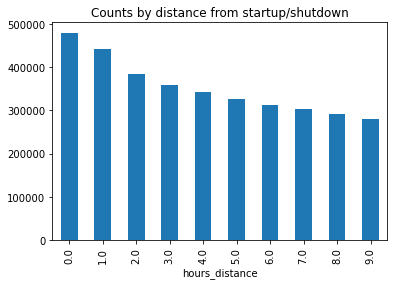

In [25]:
cems[cems['hours_distance'] < 10].groupby('hours_distance').size().plot.bar(title="Counts by distance from startup/shutdown")

Are ramps symmetrical between startup/shutdown?

In [26]:
cems['is_startup'] = cems['hours_from_startup'] < cems['hours_to_shutdown']

In [27]:
# randomly allocate midpoints
rng = np.random.default_rng(seed=2)
rand_midpoints = (cems['hours_from_startup'] == cems['hours_to_shutdown']) & rng.choice(np.array([True, False]), size=len(cems))
cems.loc[rand_midpoints, 'is_startup'] = True

In [28]:
del rand_midpoints

In [29]:
max_ramps = cems.rename(columns={'unit_id_epa': 'unit'}).groupby(['unit', 'hours_distance', 'is_startup'])['abs_ramp_factor'].max()

In [30]:
max_ramps = max_ramps[max_ramps != 0].reset_index() # drop empty generators

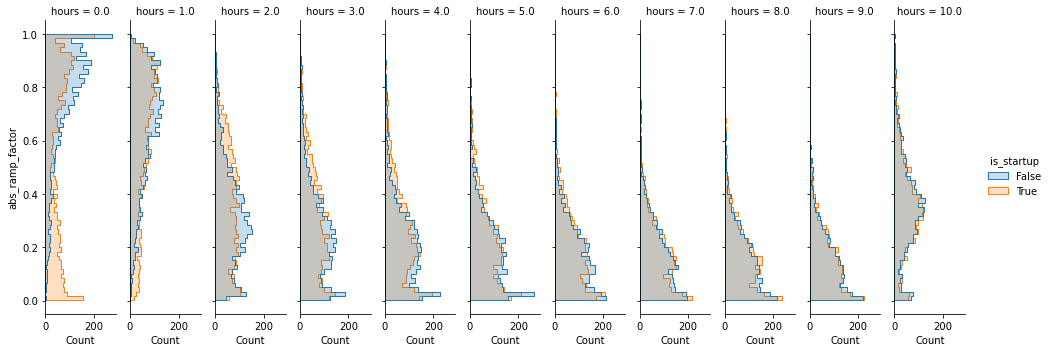

In [31]:
# Distribution of MAXIMUM ramp factor faceted by distance from startup/shutdown
# Note that the last category is 10+ hours, not =10
a = sns.displot(data=max_ramps, col='hours_distance', y='abs_ramp_factor', hue='is_startup', kind="hist", aspect=0.25, element="step")
a.set_titles('hours = {col_name}')

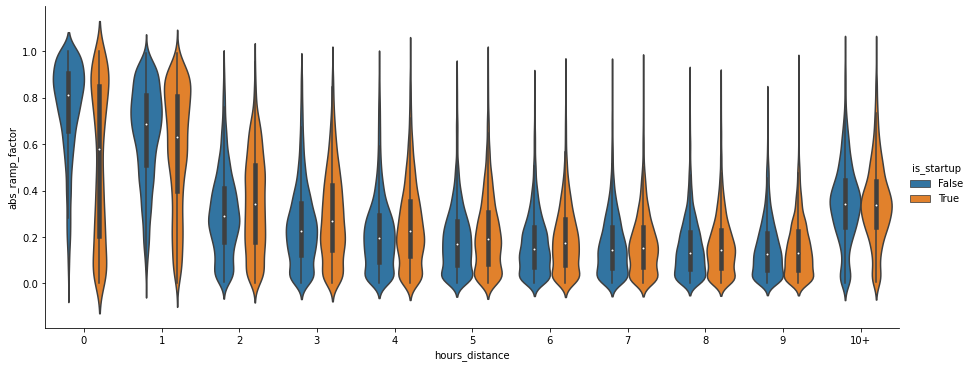

In [32]:
# Distribution of MAXIMUM ramp factor faceted by distance from startup/shutdown
# Note that the last category is 10+ hours, not =10
a = sns.catplot(data=max_ramps, x='hours_distance', y='abs_ramp_factor', hue='is_startup', kind="violin", aspect=2.5)
a.set_xticklabels(list(range(10))+['10+'])

### Ramp filtering by hour

In [33]:
df2 = cems.loc[idx[90035, '2019-09-09':'2019-09-13'], :]
is_zero = df2['gross_load_mw'].eq(0)
startups = df2['hours_from_startup'].le(5)
shutdowns = df2['hours_to_shutdown'].le(5)
ramps = df2['abs_ramp_factor']

In [34]:
filter_downtime = df2['hours_distance'] <= 5
max_dt_ramp = df2.loc[filter_downtime, 'abs_ramp_factor'].idxmax()
max_op_ramp = df2.loc[~filter_downtime, 'abs_ramp_factor'].idxmax()

In [35]:
def plot_detailed_downtime_ramps(df, zeros, startups, shutdowns, max_downtime_ramp, max_operating_ramp, ax):
    ax.plot(df.index.get_level_values("operating_datetime_utc"),
            df['gross_load_mw'],
            marker='.',
            markersize=2,
            lw=1,
            c='gray'
           )
    for color, filter_ in {'gainsboro': zeros, 'green': startups, 'firebrick': shutdowns}.items():
        filtered = df.loc[filter_, 'gross_load_mw']
        ax.scatter(x=filtered.index.get_level_values("operating_datetime_utc"),
                  y=filtered,
                  c=color,
                  s=4 if color == 'gainsboro' else 15,
                  zorder=10) # force plotting on top of time series
    for color, ramp in {'red': max_downtime_ramp, 'lime': max_operating_ramp}.items():
        max_ramp = df.loc[(ramp[0], ramp[1] - pd.Timedelta('1h')):ramp]
        ax.plot(max_ramp.index.get_level_values("operating_datetime_utc"),
                max_ramp['gross_load_mw'],
                marker='x',
                markersize=10,
                lw=3,
                c=color,
                zorder=8,
               )

In [36]:
def plot_ramps(ramps, ax):
    ax.stairs(ramps.iloc[0:-1],
              ramps.index.get_level_values("operating_datetime_utc"),
              fill=True,
              color='lightgray',
             )

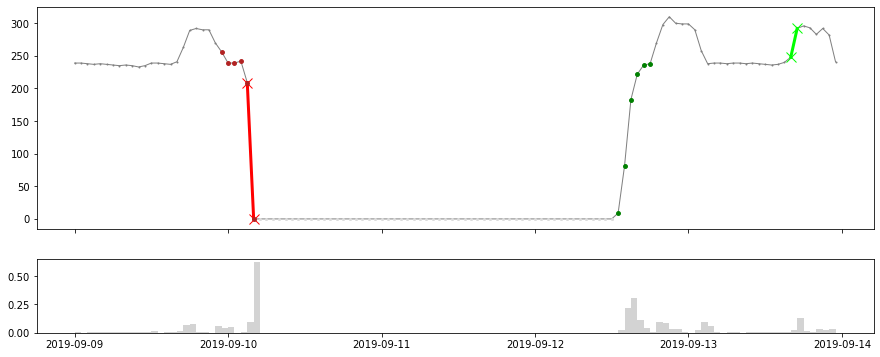

In [37]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(15,6), gridspec_kw={'height_ratios': [3, 1]})
plot_detailed_downtime_ramps(df2, is_zero, startups, shutdowns, max_dt_ramp, max_op_ramp, axes[0])
plot_ramps(ramps, axes[1])

In [38]:
def plot_downtime_ramps(df, slicer=None, max_ramp_distance=5, figsize=(15,6), zoom=None, **kwargs):
    """
    Time vs. Gross Load, highlighting downtime and ramps.
    """
    df = df.loc[slicer, :]
    is_zero = df['gross_load_mw'].eq(0)
    startups = df['hours_from_startup'].le(max_ramp_distance)
    shutdowns = df['hours_to_shutdown'].le(max_ramp_distance)
    
    fig, ax = plt.subplots(figsize=figsize)
    if len(df) < 30*24 and zoom is None:
        zoom = False
    else:
        plot = ax.plot
    
    sns.scatterplot(
        x="operating_datetime_utc",
        y="gross_load_mw",
        data=df, hue=col,
        linewidth=0, s=3, alpha=0.25,
        palette=["red", "black"],
    )
    plt.title(f"Ramp Rate Load Outliers; Unit: {unit_label}; Max Ramp: {df.max_ramp_mw.max():.2f}MW")
    plt.legend(loc="lower left", title=col)
    plt.show();

## Uptime Analysis

In [39]:
event_dfs = []
for grp, df in units['gross_load_mw']:
    event_dfs.append(_find_uptime(df, multiindex_key=grp))
events = pd.concat(event_dfs)
del event_dfs

In [40]:
events

startup                  shutdown
unit_id_epa event                                                    
1           0     2019-03-03 03:00:00+00:00 2019-03-03 09:00:00+00:00
            1     2019-03-04 18:00:00+00:00 2019-03-08 18:00:00+00:00
            2     2019-05-18 18:00:00+00:00 2019-05-30 05:00:00+00:00
            3     2019-07-10 11:00:00+00:00 2019-07-18 04:00:00+00:00
            4     2019-09-13 01:00:00+00:00 2019-10-01 23:00:00+00:00
...                                     ...                       ...
91323       21    2019-11-11 21:00:00+00:00 2019-11-12 05:00:00+00:00
            22    2019-11-12 22:00:00+00:00 2019-11-13 03:00:00+00:00
            23    2019-11-18 21:00:00+00:00 2019-11-19 03:00:00+00:00
            24    2019-11-21 22:00:00+00:00 2019-11-22 05:00:00+00:00
            25    2019-11-22 21:00:00+00:00 2019-11-23 07:00:00+00:00

[241014 rows x 2 columns]

In [41]:
# how many units have 0 uptime?
len(cems.index.levels[0]) - len(events.index.levels[0])

565

In [42]:
events['duration'] = events['shutdown'] - events['startup']

In [43]:
event_aggs = events['duration'].dt.total_seconds().div(60*60).groupby(level='unit_id_epa').describe().add_suffix('_uptime')
event_aggs

,count_uptime,mean_uptime,std_uptime,min_uptime,25%_uptime,50%_uptime,75%_uptime,max_uptime
unit_id_epa,,,,,,,,
1,6.0,179.666667,164.548676,6.0,70.50,140.5,252.50,454.0
2,8.0,116.000000,86.620684,2.0,71.00,130.0,142.00,274.0
4,12.0,238.166667,148.816442,7.0,155.25,211.5,350.75,506.0
5,11.0,517.181818,567.509263,4.0,14.50,326.0,813.00,1638.0
6,14.0,558.000000,701.084544,3.0,6.75,291.5,829.25,1983.0
...,...,...,...,...,...,...,...,...
91295,17.0,259.705882,332.795501,2.0,11.00,118.0,377.00,1150.0
91296,16.0,260.625000,235.627637,2.0,85.00,189.0,376.25,802.0
91299,22.0,5.909091,3.637229,2.0,3.00,4.5,7.00,15.0


In [44]:
# count can be thrown off by NaT values in duration. Use row count instead
event_aggs['count_uptime'] = events.groupby(level='unit_id_epa').size()

array([[<AxesSubplot:title={'center':'mean_uptime'}>,
        <AxesSubplot:title={'center':'std_uptime'}>,
        <AxesSubplot:title={'center':'min_uptime'}>],
       [<AxesSubplot:title={'center':'25%_uptime'}>,
        <AxesSubplot:title={'center':'50%_uptime'}>,
        <AxesSubplot:title={'center':'75%_uptime'}>],
       [<AxesSubplot:title={'center':'max_uptime'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

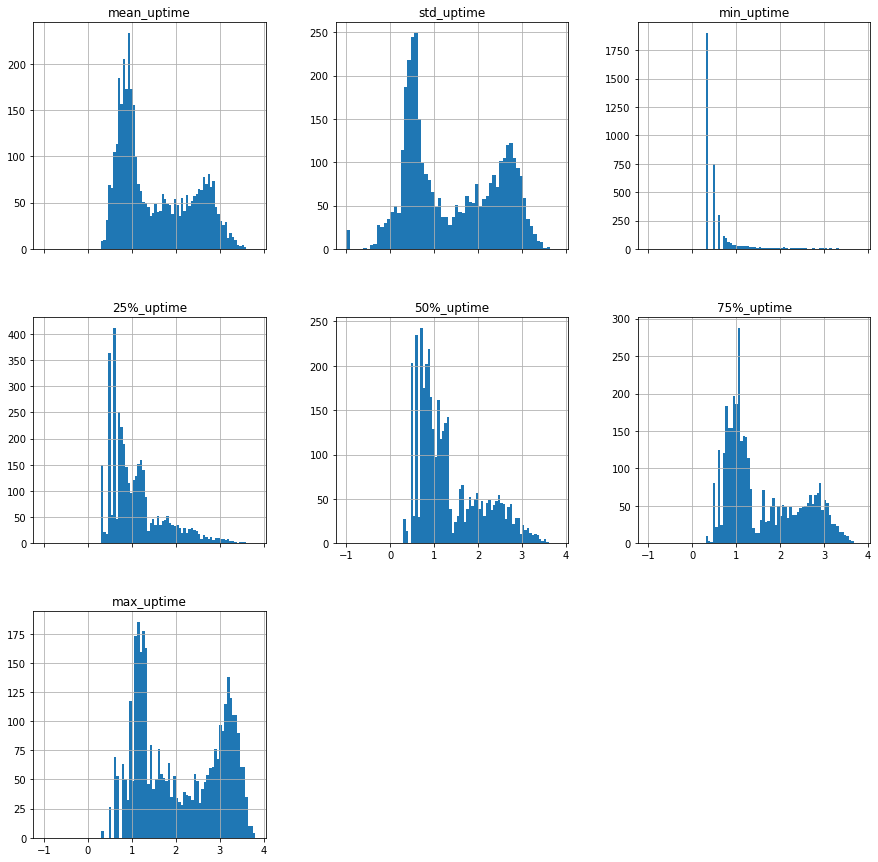

In [45]:
event_aggs.drop(columns=['count_uptime']).replace(0, 1e-1).transform(np.log10).hist(figsize=(15,15), bins=60, sharex=True)

<AxesSubplot:>

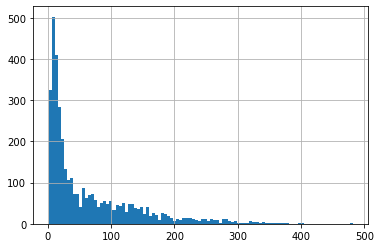

In [46]:
event_aggs['count_uptime'].hist(bins=100)

<AxesSubplot:>

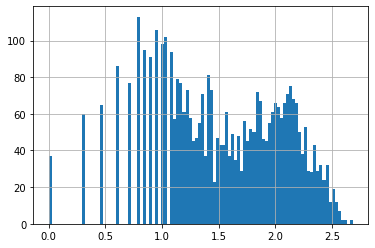

In [47]:
event_aggs['count_uptime'].transform(np.log10).hist(bins=100)

In [48]:
event_aggs = event_aggs.join(cems['gross_load_mw'].gt(0).groupby(level='unit_id_epa').mean().rename('utilization'), how='left')

<AxesSubplot:>

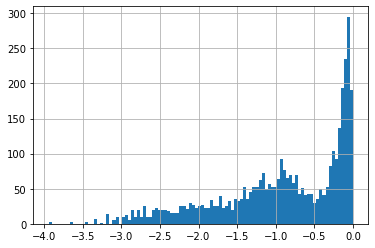

In [49]:
# log10 counts of non-zero generation hours, with 0 hours mapped to -1
event_aggs['utilization'].transform(np.log10).hist(bins=100)

Is there a simple way to classify 'peakers' from 'baseload'? Is that distinction even meaningful?

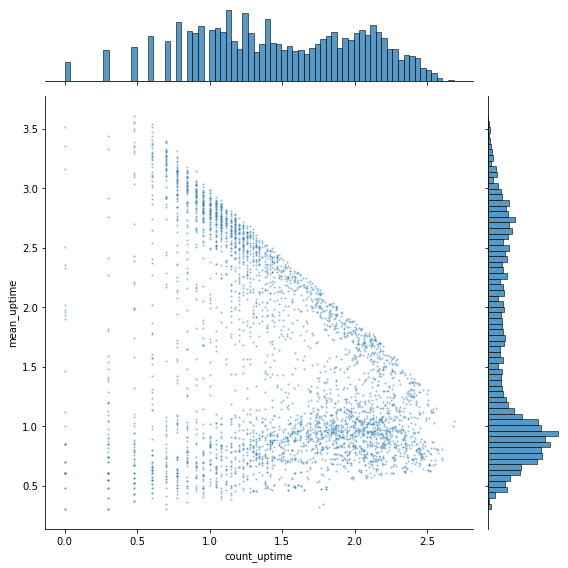

In [50]:
sns.jointplot(data=event_aggs.transform(np.log10), x='count_uptime', y='mean_uptime', s=4, alpha=0.5, height=8, marginal_kws=dict(bins=70))

It looks like there are two fairly distinct populations of plants which look to be mostly linearly separable using only these two dimensions. But these two populations are NOT peakers vs baseload; these two populations are simply 'runs most hours' vs 'runs rarely'.

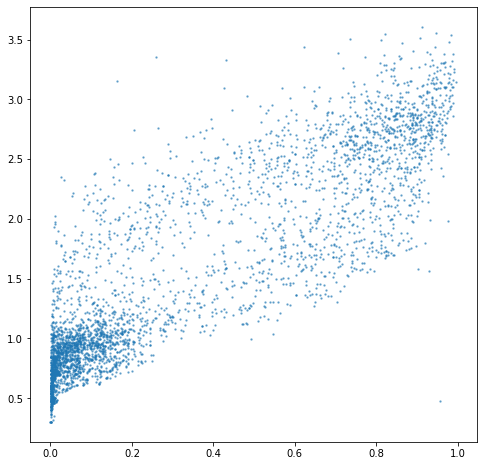

In [51]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x=event_aggs['utilization'], y=event_aggs['mean_uptime'].transform(np.log10), s=2, alpha=0.5)

<AxesSubplot:>

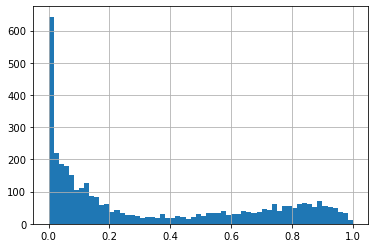

In [52]:
event_aggs['utilization'].hist(bins=60)

I'll try calculating ramp rates and coloring the above plot by that.

## Max Ramps

In [53]:
hours_thresh = 5
downtime_filter = cems['hours_distance'] <= hours_thresh # use < so that NaN are included in operating group
downtime_ramps = cems.loc[downtime_filter].groupby(level='unit_id_epa')['abs_ramp_factor'].describe().add_suffix('_dt')
operating_ramps = cems.loc[~downtime_filter].groupby(level='unit_id_epa')['abs_ramp_factor'].describe().add_suffix('_op')

In [54]:
event_aggs = event_aggs.join([downtime_ramps, operating_ramps], how='left')

In [55]:
del downtime_ramps, operating_ramps

array([[<AxesSubplot:title={'center':'max_dt'}>,
        <AxesSubplot:title={'center':'max_op'}>]], dtype=object)

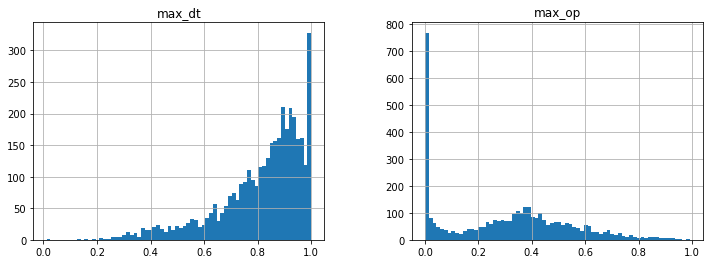

In [56]:
event_aggs[['max_dt', 'max_op']].hist(bins=70, figsize=(12,4))

In [57]:
event_aggs.skew()

count_uptime     1.685436
mean_uptime      3.736420
std_uptime       3.153468
min_uptime      13.004185
25%_uptime       8.295462
50%_uptime       5.275660
75%_uptime       3.478184
max_uptime       1.774790
utilization      0.579245
count_dt         1.611983
mean_dt         -0.033855
std_dt           0.712131
min_dt          29.957054
25%_dt           2.378855
50%_dt           0.655074
75%_dt           1.148860
max_dt          -1.293927
count_op        -2.345774
mean_op          1.401370
std_op           0.868517
min_op           0.000000
25%_op           8.722062
50%_op           4.133827
75%_op           2.181352
max_op           0.256054
dtype: float64

In [58]:
event_aggs = event_aggs.join(event_aggs
                             .loc[:, event_aggs.skew().gt(1)]
                             .replace(0, np.nan)
                             .transform(np.log10)
                             .add_prefix('log_')
                            )

In [59]:
event_aggs = event_aggs.join(event_aggs
                             .loc[:, event_aggs.skew().lt(-1)]
                             .transform(lambda x: x.div(x.max())) # normalize
                             .mul(-1).add(1) # complement; 1 - x
                             .replace(0, np.nan)
                             .transform(np.log10)
                             .add_prefix('log_comp_')
                            )

In [60]:
event_aggs.columns

Index(['count_uptime', 'mean_uptime', 'std_uptime', 'min_uptime', '25%_uptime',
       '50%_uptime', '75%_uptime', 'max_uptime', 'utilization', 'count_dt',
       'mean_dt', 'std_dt', 'min_dt', '25%_dt', '50%_dt', '75%_dt', 'max_dt',
       'count_op', 'mean_op', 'std_op', 'min_op', '25%_op', '50%_op', '75%_op',
       'max_op', 'log_count_uptime', 'log_mean_uptime', 'log_std_uptime',
       'log_min_uptime', 'log_25%_uptime', 'log_50%_uptime', 'log_75%_uptime',
       'log_max_uptime', 'log_count_dt', 'log_min_dt', 'log_25%_dt',
       'log_75%_dt', 'log_mean_op', 'log_25%_op', 'log_50%_op', 'log_75%_op',
       'log_comp_max_dt', 'log_comp_count_op', 'log_comp_log_75%_dt'],
      dtype='object')

In [61]:
subset = ['log_count_uptime', 'log_mean_uptime', 'utilization', 'log_count_dt', 'log_comp_count_op', 'max_op', 'log_comp_max_dt', 'mean_dt', 'log_mean_op',]

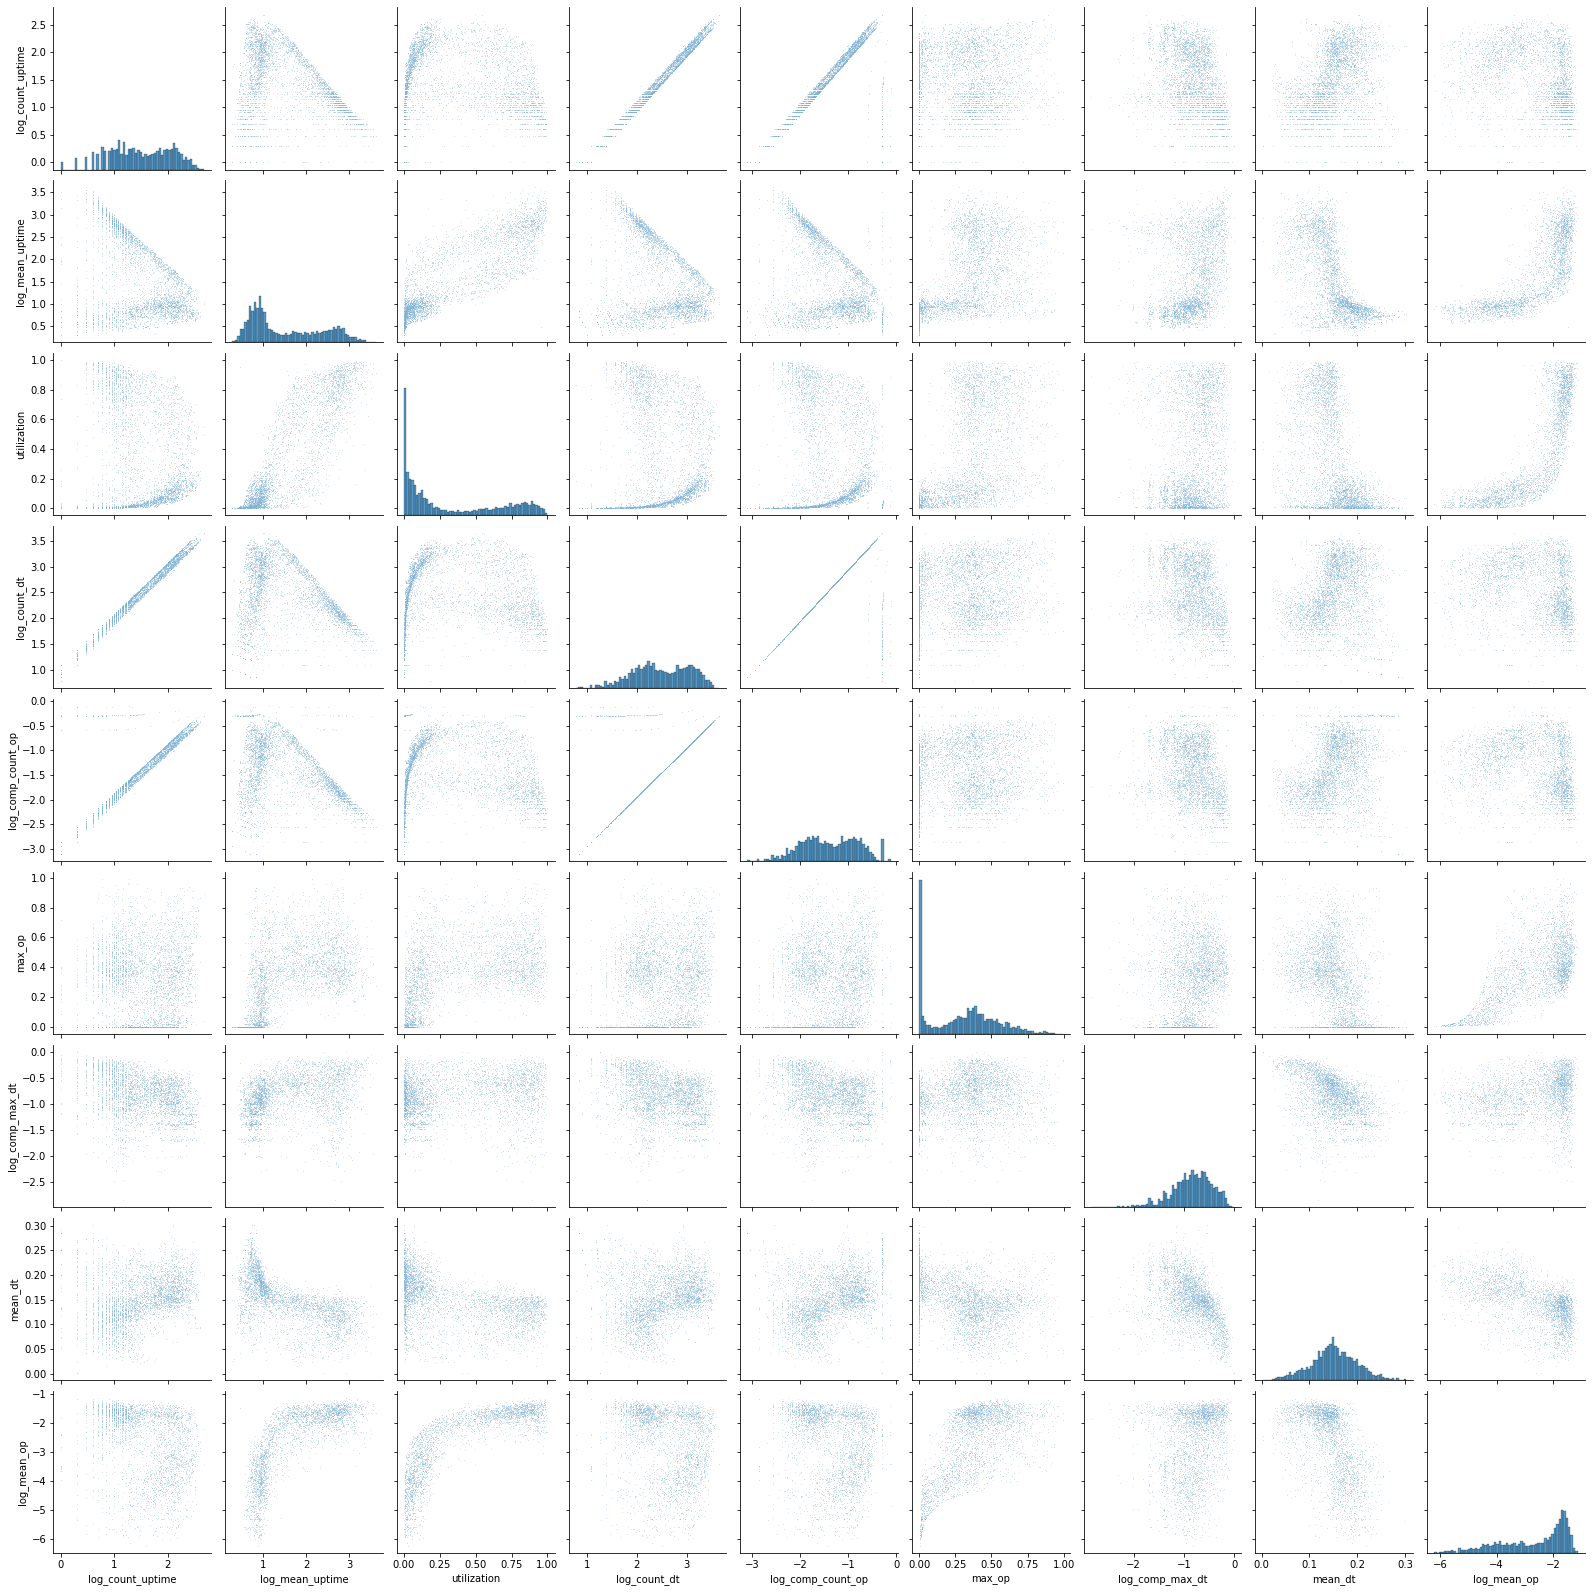

In [62]:
sns.pairplot(data=event_aggs[subset], diag_kws={'bins':60}, markers='.', plot_kws=dict(alpha=0.4, s=3))

<AxesSubplot:xlabel='log_count_uptime', ylabel='log_mean_uptime'>

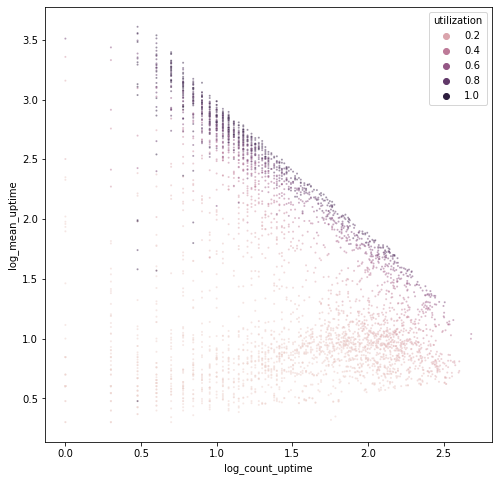

In [63]:
fix, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=event_aggs, x='log_count_uptime', y='log_mean_uptime', hue='utilization', s=4, alpha=0.5, ax=ax)

<AxesSubplot:xlabel='log_count_uptime', ylabel='log_mean_uptime'>

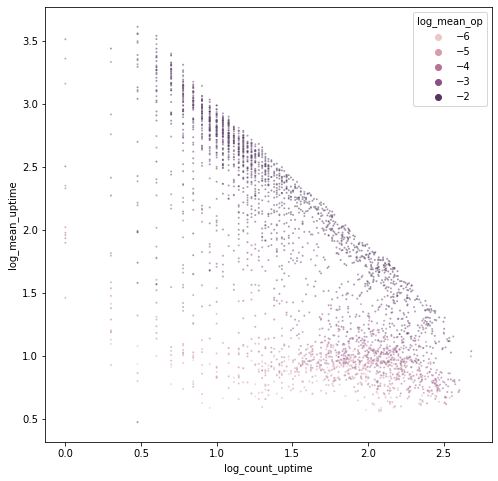

In [64]:
fix, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=event_aggs, x='log_count_uptime', y='log_mean_uptime', hue='log_mean_op', s=4, alpha=0.5, ax=ax)

<AxesSubplot:xlabel='log_mean_uptime', ylabel='utilization'>

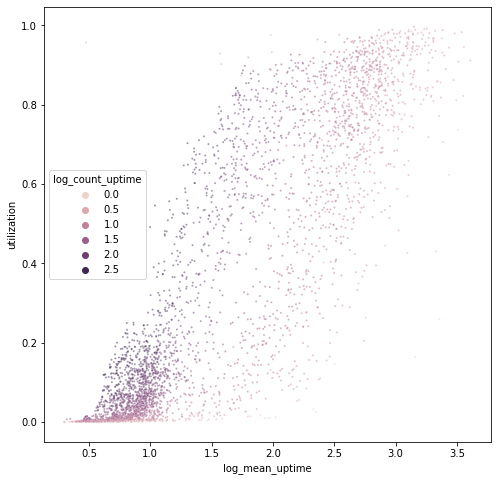

In [65]:
fix, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=event_aggs, x='log_mean_uptime', y='utilization', hue='log_count_uptime', s=4, alpha=0.5, ax=ax)

<AxesSubplot:xlabel='log_count_uptime', ylabel='log_count_dt'>

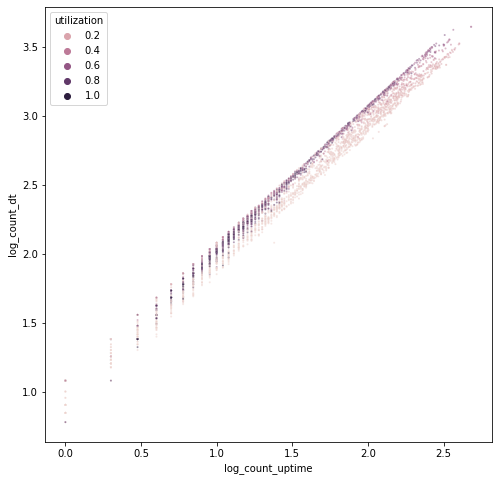

In [66]:
fix, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=event_aggs, x='log_count_uptime', y='log_count_dt', hue='utilization', s=4, alpha=0.5, ax=ax)

## Visualize ramps

In [67]:
rng = np.random.default_rng(seed=42)
def random_unit():
    id_ = rng.choice(cems.index.levels[0])
    return cems.loc[idx[id_,:],:]

<AxesSubplot:>

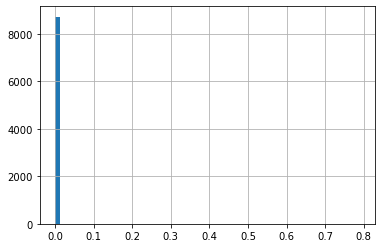

In [68]:
unit = random_unit()
unit['abs_ramp_factor'].hist(bins=60)

<AxesSubplot:>

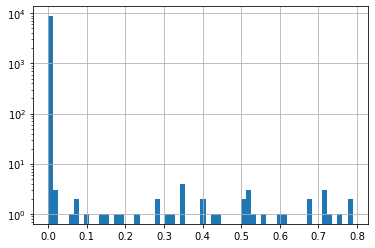

In [69]:
unit['abs_ramp_factor'].hist(bins=60, log=True)

The following was an attempt to convert event data back into timeseries. It failed due to performance issues with my implementation. I'm sure there is a way to do it, but I solved this problem by avoiding the events table entirely using the methods above.

In [70]:
raise Exception # stop 'run all cells' from continuing down

Exception: 

In [ ]:
cems.loc[:,['hours_from_startup', 'hours_to_shutdown']] = np.nan

In [ ]:
cems = cems.astype({'hours_from_startup': np.float32, 'hours_to_shutdown': np.float32}, copy=False)
cems.dtypes

In [ ]:
hr = pd.Timedelta('1h')
min_timestamp = cems.index.levels[1][0]
max_timestamp = cems.index.levels[1][-1]
full_timeseries = pd.date_range(start=min_timestamp, end=max_timestamp, freq='h', tz='UTC').to_series()
idx = pd.IndexSlice

In [ ]:
# this doesn't work because it is horrifically inefficient. Something with the cems.loc[...] assignments
for index, ser in events.iterrows():
    # move bounds in by 1 hour because indexing is inclusive
    start = ser['startup'] + hr
    end = ser['shutdown'] - hr
    # if NaT, use first/last timestamp
    if start is pd.NaT:
        start = cems.loc[idx[1,:],:].index.get_level_values(level='operating_datetime_utc')[0]
    if end is pd.NaT:
        end = cems.loc[idx[1,:],:].index.get_level_values(level='operating_datetime_utc')[-1]
    
    from_startup = full_timeseries[start:end].sub(ser['startup']).dt.total_seconds().div(3600).to_numpy(dtype=np.float32) # hours
    to_shutdown = full_timeseries[start:end].sub(ser['shutdown']).dt.total_seconds().div(-3600).to_numpy(dtype=np.float32) # hours, .div(-3600) to fix sign
    
    cems.loc[idx[index[0], start:end], 'hours_from_startup'] = from_startup
    cems.loc[idx[index[0], start:end], 'hours_to_shutdown'] = to_shutdown
    #new_df = pd.DataFrame({'hours_from_startup': from_startup, 'hours_to_shutdown': to_shutdown}, index=cems.loc[idx[index[0], start:end],:].index)
    #cems.update(new_df)
    if index[0] > 10:
        break
    #subset = cems.loc[idx[index[0], start:end], ['hours_from_startup', 'hours_to_shutdown']]